<a href="https://colab.research.google.com/github/Anubhav3084/Deep-Learning/blob/main/PyTorch_Tutorial/GANs/MNIST/GANs_MNIST_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Data Loading and preprocessing**

In [1]:
import torch
import torchvision
from torchvision.transforms import ToTensor, Normalize, Compose
from torchvision.datasets import MNIST

mnist = MNIST(root='data',
              train=True,
              download=True,
              transform=Compose([ToTensor(), Normalize(mean=(0.5,), std=(0.5,))]))

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [4]:
print(len(mnist))

60000


In [6]:
def denorm(x):
    out = (x + 1)/2
    return out.clamp(0, 1)

Label:  5


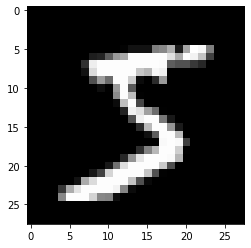

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

img, label = mnist[0]
img_norm = denorm(img)
plt.imshow(img_norm[0], cmap='gray')
print('Label: ', label)

In [8]:
from torch.utils.data import DataLoader

batch_size = 100
data_loader = DataLoader(mnist, batch_size, shuffle=True)

First batch
torch.Size([100, 1, 28, 28])
tensor([7, 5, 8, 0, 8, 0, 9, 2, 3, 0, 4, 8, 3, 4, 0, 2, 2, 6, 8, 9, 4, 8, 2, 6,
        4, 2, 4, 0, 3, 6, 7, 5, 3, 6, 1, 7, 4, 5, 0, 5, 8, 8, 7, 7, 4, 7, 3, 1,
        4, 2, 2, 7, 1, 8, 9, 3, 3, 3, 1, 0, 0, 6, 2, 0, 7, 8, 9, 1, 2, 9, 7, 9,
        8, 4, 8, 1, 1, 2, 1, 3, 4, 4, 0, 9, 5, 2, 8, 5, 0, 1, 6, 7, 8, 0, 9, 6,
        5, 8, 9, 9])


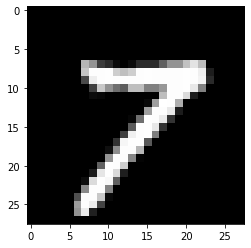

In [10]:
for img_batch, label_batch in data_loader:
    print('First batch')
    print(img_batch.shape)
    plt.imshow(img_batch[0][0], cmap='gray')
    print(label_batch)
    break

### **Device configuration**

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

### **Model**

#### **Discriminator**

In [12]:
image_size = 784
hidden_size = 256

In [16]:
import torch.nn as nn
from torchsummary import summary

D = nn.Sequential(
    nn.Linear(image_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, 1),
    nn.Sigmoid()
)

In [17]:
D.to(device)
summary(D, (784,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 256]         200,960
         LeakyReLU-2                  [-1, 256]               0
            Linear-3                  [-1, 256]          65,792
         LeakyReLU-4                  [-1, 256]               0
            Linear-5                    [-1, 1]             257
           Sigmoid-6                    [-1, 1]               0
Total params: 267,009
Trainable params: 267,009
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 1.02
Estimated Total Size (MB): 1.03
----------------------------------------------------------------


#### **Generator**

In [19]:
latent_size = 64

In [24]:
G = nn.Sequential(
    nn.Linear(latent_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, image_size),
    nn.Tanh()
)

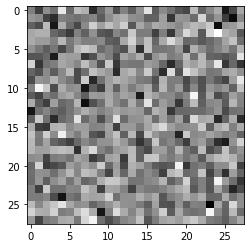

In [25]:
y = G(torch.randn(1, latent_size))
gen_imgs = denorm(y.reshape((-1, 28,28)).detach())
plt.imshow(gen_imgs[0], cmap='gray')

In [26]:
G.to(device)
summary(G, (64,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 256]          16,640
              ReLU-2                  [-1, 256]               0
            Linear-3                  [-1, 256]          65,792
              ReLU-4                  [-1, 256]               0
            Linear-5                  [-1, 784]         201,488
              Tanh-6                  [-1, 784]               0
Total params: 283,920
Trainable params: 283,920
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 1.08
Estimated Total Size (MB): 1.10
----------------------------------------------------------------


### **Training**

In [28]:
Loss_function = nn.BCELoss()
opt_d = torch.optim.Adam(D.parameters(), lr=0.0002)
opt_g = torch.optim.Adam(G.parameters(), lr=0.0002)

#### **Discriminator**

In [29]:
def train_discriminator(images):
    
    # reset gradients
    opt_d.zero_grad()

    # loss for real images
    real_preds = D(images)
    real_labels = torch.ones(batch_size, 1).to(device)
    d_loss_real = Loss_function(real_preds, real_labels)
    real_score = torch.mean(real_preds).item()

    # loss for fake images
    z = torch.randn(batch_size, latent_size).to(device)
    fake_images = G(z)
    fake_preds = D(fake_images)
    fake_labels = torch.zeros(batch_size, 1).to(device)
    d_loss_fake = Loss_function(fake_preds, fake_labels)
    fake_score = torch.mean(fake_preds).item()

    # combine losses
    d_loss = d_loss_real + d_loss_fake

    # compute gradients
    d_loss.backward()

    # update parameters using backprop
    opt_d.step()

    return d_loss, real_score, fake_score

#### **Generator**

In [30]:
def train_generator():

    # reset gradients
    opt_g.zero_grad()
    
    # generate fake images and calculate loss
    z = torch.randn(batch_size, latent_size).to(device)
    fake_images = G(z)
    labels = torch.ones(batch_size, 1).to(device)
    g_loss = Loss_function(D(fake_images), labels)

    # Backprop and optimize
    g_loss.backward()
    opt_g.step()

    return g_loss, fake_images

### **Helper funtions to convert images to video for visualization**

In [34]:
import os

sample_dir = 'samples'
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

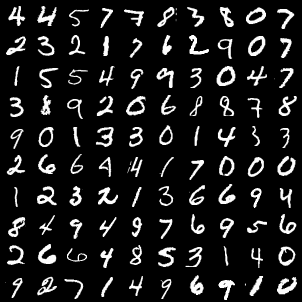

In [35]:
from IPython.display import Image
from torchvision.utils import save_image

# save some real images
for images, _ in data_loader:
    images = images.reshape(images.size(0), 1, 28, 28)
    save_image(denorm(images), os.path.join(sample_dir, 'real_images.png'), nrow=10)
    break

Image(os.path.join(sample_dir, 'real_images.png'))

Saving fake_images-0000.png


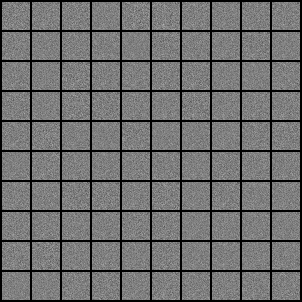

In [38]:
# fix some random vectors to compare the generated images (just like setting seed value)

sample_vectors = torch.randn(batch_size, latent_size).to(device)

def save_fake_images(index):
    fake_images = G(sample_vectors)
    fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)
    fake_fname = 'fake_images-{0:0=4d}.png'.format(index)
    print('Saving', fake_fname)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=10)

# before training
save_fake_images(0)
Image(os.path.join(sample_dir, 'fake_images-0000.png'))

### **Training the Model**

In [39]:
num_epochs = 300
total_step = len(data_loader)
d_losses, g_losses, real_scores, fake_scores = [], [], [], []

for epoch in range(num_epochs):
    for i, (images, _) in enumerate(data_loader):
        
        # load a batch & transform to vectors
        images = images.reshape(batch_size, -1).to(device)

        # train the discriminator and generator
        d_loss, real_score, fake_score = train_discriminator(images)
        g_loss, fake_images = train_generator()

        # inspect the losses
        if (i + 1) % 200 == 0:
            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())
            real_scores.append(real_score)
            fake_scores.append(fake_score)
            print('Epoch [{}/{}], Step[{}/{}], d_loss: {:.4f}, g_loss{:.4f}, real_score [D(x)]: {:.2f}, fake_score [D(G(z))]: {:.2f}'.format(
                epoch, num_epochs, i + 1, total_step, d_loss, g_loss, real_score, fake_score
            ))

    # sample and save images
    save_fake_images(epoch + 1)

Epoch [0/300], Step[200/600], d_loss: 0.0294, g_loss4.6430, real_score [D(x)]: 0.99, fake_score [D(G(z))]: 0.02
Epoch [0/300], Step[400/600], d_loss: 0.0566, g_loss6.4402, real_score [D(x)]: 0.98, fake_score [D(G(z))]: 0.03
Epoch [0/300], Step[600/600], d_loss: 0.0325, g_loss5.6199, real_score [D(x)]: 0.99, fake_score [D(G(z))]: 0.02
Saving fake_images-0001.png
Epoch [1/300], Step[200/600], d_loss: 0.0434, g_loss5.9496, real_score [D(x)]: 0.99, fake_score [D(G(z))]: 0.03
Epoch [1/300], Step[400/600], d_loss: 0.0533, g_loss5.2368, real_score [D(x)]: 0.98, fake_score [D(G(z))]: 0.04
Epoch [1/300], Step[600/600], d_loss: 0.6141, g_loss5.5145, real_score [D(x)]: 0.79, fake_score [D(G(z))]: 0.10
Saving fake_images-0002.png
Epoch [2/300], Step[200/600], d_loss: 0.5485, g_loss3.1118, real_score [D(x)]: 0.79, fake_score [D(G(z))]: 0.08
Epoch [2/300], Step[400/600], d_loss: 0.9543, g_loss3.5492, real_score [D(x)]: 0.80, fake_score [D(G(z))]: 0.36
Epoch [2/300], Step[600/600], d_loss: 0.1562, g_

### **Save the model checkpoints**

In [47]:
torch.save(G.state_dict(), 'G.pth')
torch.save(D.state_dict(), 'D.pth')

### **Display some images**

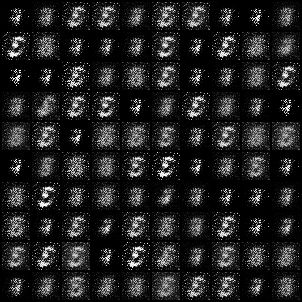

In [48]:
Image('./samples/fake_images-0010.png')

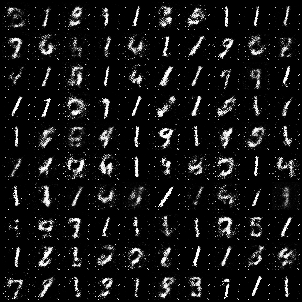

In [49]:
Image('./samples/fake_images-0050.png')

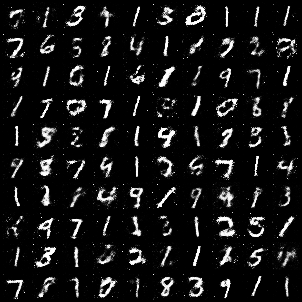

In [50]:
Image('./samples/fake_images-0100.png')

### **Convert to video for better visualization**

In [51]:
import cv2
from IPython.display import FileLink

vid_fname = 'gans_training_mnist.avi'

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'fake_images' in f]
files.sort()

out = cv2.VideoWriter(vid_fname, cv2.VideoWriter_fourcc(*'MP4V'), 8, (302, 302))
[out.write(cv2.imread(fname)) for fname in files]
out.release()
FileLink('gans_training_mnist.avi')

/content/gans_training_mnist.avi

### **Plot losses and scores**

Text(0.5, 1.0, 'Losses')

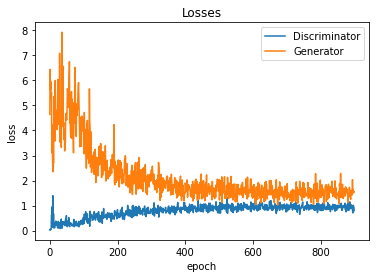

In [52]:
plt.plot(d_losses, '-')
plt.plot(g_losses, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses')

Text(0.5, 1.0, 'Scores')

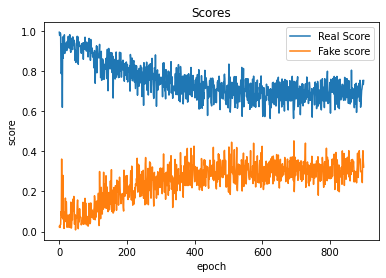

In [53]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real Score', 'Fake score'])
plt.title('Scores')